# Transfer learning with TensorFlow Hub

## Setup

In [1]:
import numpy as np
import time

import PIL.Image as Image
import matplotlib.pylab as plt

import tensorflow as tf
import tensorflow_hub as hub

import datetime

%load_ext tensorboard

## An ImageNet classifier

We will start by using a classifier model pre-trained on the ImageNet benchmark dataset -no initial training is required!

### Download the classifier

We will select a InceptionV3 pre-trained model from TensorFlow Hub and wrap it as a Keras layer with `hub.KerasLayer`.

In [2]:
inception_v3_url = "https://tfhub.dev/google/imagenet/inception_v3/classification/5"

IMAGE_SHAPE = (224, 224)

classifer = tf.keras.Sequential([
    hub.KerasLayer(inception_v3_url, input_shape=IMAGE_SHAPE+(3,))
])

### Run it on a single image

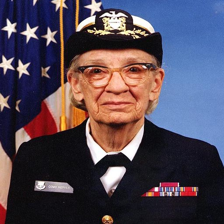

In [3]:
# Downloading a single image
grace_hopper = tf.keras.utils.get_file('image.jpg', 'https://storage.googleapis.com/download.tensorflow.org/example_images/grace_hopper.jpg')
grace_hopper = Image.open(grace_hopper).resize(IMAGE_SHAPE)
grace_hopper

In [4]:
grace_hopper = np.array(grace_hopper)/255.0
grace_hopper.shape

(224, 224, 3)

In [5]:
# Add a batch dimension and pass the image to the model
result = classifer.predict(grace_hopper[np.newaxis, ...])
result.shape

1/1 [==============================] - 6s 6s/step


(1, 1001)

The result is a 1001-element vector of logits, rating the probability of each class for the image.

In [6]:
# The top class ID can be found with tf.math.argmax
predicted_class = tf.math.argmax(result[0], axis=-1)
predicted_class

<tf.Tensor: shape=(), dtype=int64, numpy=458>

### Decode the predictions

In [7]:
# Fetch the ImageNet dataset labels to decode the predictions
labels_path = tf.keras.utils.get_file('ImageNetLabels.txt', 'https://storage.googleapis.com/download.tensorflow.org/data/ImageNetLabels.txt')
imagenet_labels = np.array(open(labels_path).read().splitlines())

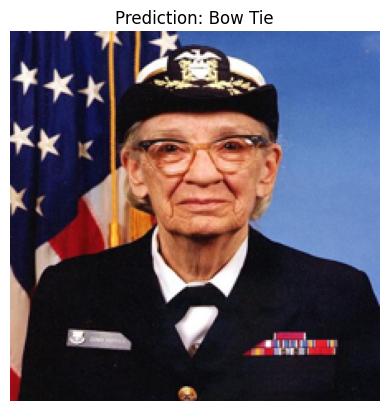

In [8]:
# Take the predicted class label
plt.imshow(grace_hopper)
plt.axis('off')
predicted_class_name = imagenet_labels[predicted_class]
plt.title('Prediction: ' + predicted_class_name.title());

## Simple transfer learning

But what if you want to create a custom classifier using your own dataset that has classes that aren't included in the original ImageNet dataset?

To do that, you can:
1. Select a pre-trained model from TensorFlow Hub; and
2. Retrain the top (last) layer to recognize the classes from your custom dataset.

### Dataset

In this example, we will use the TensorFlow flowers dataset.

In [9]:
import pathlib

data_file = tf.keras.utils.get_file(
    'flower_photos.tgz',
    'https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz',
    cache_dir='.',
    extract=True
)

data_root = pathlib.Path(data_file).with_suffix('')

First, load this data into the model using the image data off disk with `tf.keras.utils.image_dataset_from_directory`, which will generate a `tf.data.Dataset`.

In [10]:
batch_size = 32
img_height = 224
img_width = 224

train_ds = tf.keras.utils.image_dataset_from_directory(
    str(data_root),
    validation_split=0.2,
    subset='training',
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    str(data_root),
    validation_split=0.2,
    subset='validation',
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

Found 3670 files belonging to 5 classes.
Using 2936 files for training.
Found 3670 files belonging to 5 classes.
Using 734 files for validation.


The flowers dataset have five classes:

In [11]:
class_names = np.array(train_ds.class_names)
print(class_names)

['daisy' 'dandelion' 'roses' 'sunflowers' 'tulips']


Second, because TensorFlow Hub's convention for image models is to expect float inputs in the `[0, 1]` range, use the `tf.keras.layers.Rescaling` preprocessing layer to achive this.

In [12]:
normalization_layer = tf.keras.layers.Rescaling(1./255)
train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y)) # Where x-images, y-labels.
val_ds = val_ds.map(lambda x, y: (normalization_layer(x), y)) # Where x-images, y-labels.

Third, finish the input pipeline by using buffered prefetching with `Dataset.prefecth`, so you can yield the data from disk without I/O blocking issues.

In [13]:
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [14]:
for image_batch, labels_batch in train_ds:
    print(image_batch.shape)
    print(labels_batch.shape)
    break

(32, 224, 224, 3)
(32,)


### Run the classifier on a batch of images